<h1><center>Sartorius: Complete UNet Understanding</center></h1>
                                                      
<center><img src = "https://www.innovationnewsnetwork.com/wp-content/uploads/2021/02/%C2%A9-iStock-peterschreiber.media_-696x392.jpg" width = "750" height = "500"/></center>                                                                            

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Contents</center></h2>

1. [Competition Overview](#competition-overview)    
2. [Libraries](#libraries)  
3. [Weights and Biases](#weights-and-biases)  
4. [Global Config](#global-config)  
5. [Load Datasets](#load-datasets)
6. [U-Net Model](#unet-model)
7. [References](#references)  

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:maroon; border:0; color:white' role="tab" aria-controls="home"><center>If you find this notebook useful, do give me an upvote, it helps to keep up my motivation. This notebook will be updated frequently so keep checking for furthur developments.</center></h3>

<a id="competition-overview"></a>
<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Competition Overview</center></h2>

## **<span style="color:orange;">Description</span>**


In this competition, you’ll detect and delineate distinct objects of interest in biological images depicting neuronal cell types commonly used in the study of neurological disorders. More specifically, you'll use phase contrast microscopy images to train and test your model for instance segmentation of neuronal cells. Successful models will do this with a high level of accuracy.

If successful, you'll help further research in neurobiology thanks to the collection of robust quantitative data. Researchers may be able to use this to more easily measure the effects of disease and treatment conditions on neuronal cells. As a result, new drugs could be discovered to treat the millions of people with these leading causes of death and disability.

---

## **<span style="color:orange;">Evaluation Metric</span>**

This competition is evaluated on the **mean average precision** at different intersection over union  thresholds. The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:

`IoU(A,B)= (A∩B)/(A∪B)`

---

> The competition uses a couple of medical terms which many people will be unfamiliar with. To easen out the process I am providing the foundations of the mentioned diseases and proposed treatments to give a stronger domain understanding.

<a id="libraries"></a>
<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Libraries</center></h2>

In [1]:
%%capture
!pip install ../input/segmentation-models-wheels/efficientnet_pytorch-0.6.3-py3-none-any.whl
!pip install ../input/segmentation-models-wheels/pretrainedmodels-0.7.4-py3-none-any.whl
!pip install ../input/segmentation-models-wheels/timm-0.3.2-py3-none-any.whl
!pip install ../input/segmentation-models-wheels/segmentation_models_pytorch-0.1.3-py3-none-any.whl

In [2]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp ../input/pytorch-pretrained-image-models/resnet34.pth /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth

In [3]:
%%sh
pip install -q --upgrade wandb
pip install -q timm

In [4]:
import gc
import os
import pdb
import time
import glob
import sys
import cv2
import imageio
import joblib
import math
import random
import wandb
import math

import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams.update({'font.size': 18})
plt.style.use('fivethirtyeight')

import seaborn as sns
import matplotlib
from dask import bag, diagnostics 
from mpl_toolkits.mplot3d import Axes3D

from termcolor import colored

from tqdm.notebook import tqdm

# import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, sampler

import collections.abc as container_abcs
torch._six.container_abcs = container_abcs
import segmentation_models_pytorch as smp

from sklearn.model_selection import KFold

from albumentations import (HorizontalFlip, VerticalFlip, 
                            ShiftScaleRotate, Normalize, Resize, 
                            Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2

import warnings
warnings.simplefilter('ignore')

# Activate pandas progress apply bar
tqdm.pandas()

In [24]:
# Wandb Login
import wandb
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

<a id="weights-and-biases"></a>
<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Weights and Biases (W&B)</center></h2>

<center><img src = "https://i.imgur.com/1sm6x8P.png" width = "750" height = "500"/></center>  


  
 
  
**Weights & Biases** is the machine learning platform for developers to build better models faster. 

You can use W&B's lightweight, interoperable tools to 
- quickly track experiments, 
- version and iterate on datasets, 
- evaluate model performance, 
- reproduce models, 
- visualize results and spot regressions, 
- and share findings with colleagues. 

Set up W&B in 5 minutes, then quickly iterate on your machine learning pipeline with the confidence that your datasets and models are tracked and versioned in a reliable system of record.

In this notebook I will use Weights and Biases's amazing features to perform wonderful visualizations and logging seamlessly. 

<a id="global-config"></a>
<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Global Config</center></h2>

In [22]:
class config:
    DIRECTORY_PATH = "../input/sartorius-cell-instance-segmentation"
    TRAIN_CSV = DIRECTORY_PATH + "/train.csv"
    TRAIN_PATH = DIRECTORY_PATH + "/train"
    TEST_PATH = DIRECTORY_PATH + "/test"
    TRAIN_SEMI_SUPERVISED_PATH = DIRECTORY_PATH + "/train_semi_supervised"
    
    SEED = 42
    
    RESNET_MEAN = (0.485, 0.456, 0.406)
    RESNET_STD = (0.229, 0.224, 0.225)

    # (336, 336)
    IMAGE_RESIZE = (224, 224)

    LEARNING_RATE = 5e-4
    EPOCHS = 10

In [7]:
# wandb config
WANDB_CONFIG = {
     'competition': 'Sartorius', 
              '_wandb_kernel': 'neuracort'
    }

In [8]:
def set_seed(seed=config.SEED):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed()

<a id="load-datasets"></a>
<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Load Datasets</center></h2>

## **<span style="color:orange;">Understanding the Structure of the Dataset</span>**

> ### **<span style="color:orange;">Goal of Competition</span>**
> 
> In this competition we are segmenting neuronal cells in images. The training annotations are provided as run length encoded masks, and the images are in PNG format. The number of images is small, but the number of annotated objects is quite high. The hidden test set is roughly 240 images.
> 
> ### **<span style="color:orange;">Files</span>**
> 
> **train.csv** - IDs and masks for all training objects. None of this metadata is provided for the test set.
> 
> - `id` - unique identifier for object
> 
> - `annotation` - run length encoded pixels for the identified neuronal cell
> 
> - `width` - source image width
> 
> - `height` - source image height
> 
> - `cell_type` - the cell line
> 
> - `plate_time` - time plate was created
> 
> - `sample_date` - date sample was created
> 
> - `sample_id` - sample identifier
> 
> - `elapsed_timedelta` - time since first image taken of sample
> 
> **sample_submission.csv** - a sample submission file in the correct format
> 
> **train** - train images in PNG format
> 
> **test** - test images in PNG format. Only a few test set images are available for download; the remainder can only be accessed by your notebooks when you submit.
> 
> **train_semi_supervised** - unlabeled images offered in case you want to use additional data for a semi-supervised approach.
> 
> **LIVECell_dataset_2021** - A mirror of the data from the LIVECell dataset. LIVECell is the predecessor dataset to this competition. You will find extra data for the SH-SHY5Y cell line, plus several other cell lines not covered in the competition dataset that may be of interest for transfer learning.
>
>---

In [9]:
df_train = pd.read_csv(config.TRAIN_CSV)

In [10]:
def getImagePaths(path):
    """
    Function to Combine Directory Path with individual Image Paths
    
    parameters: path(string) - Path of directory
    returns: image_names(string) - Full Image Path
    """
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in tqdm(filenames):
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

In [11]:
#Get complete image paths for train and test datasets
train_images_path = getImagePaths(config.TRAIN_PATH)
test_images_path = getImagePaths(config.TEST_PATH)
train_semi_supervised_path = getImagePaths(config.TRAIN_SEMI_SUPERVISED_PATH)

  0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1972 [00:00<?, ?it/s]

<a id="unet-model"></a>
<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>U-Net Model</center></h2>

There is large consent that successful training of **deep networks** requires many thousand annotated training samples. In the UNet paper, researchers presented a network and training strategy that relies on the strong use of **data augmentation** to use the available annotated samples more efficiently. 
  
The architecture consists of a **contracting path** to capture context and a **symmetric expanding path** that enables precise localization. They showed that such a network can be trained end-to-end from very few images and outperforms the prior best method (*a sliding-window convolutional network*) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. 
  
Moreover, the network is fast. Segmentation of a 512x512 image takes less than a second on a recent GPU. 
  
> The full
> implementation (based on Caffe) and the trained networks are available
> at http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net

---

## **<span style="color:orange;">Introduction to UNet</span>**

In the **UNet architecture** the upsampling part has a large number of feature channels, which allow the network to propagate context information to higher resolution layers. As a consequence, the **expansive path** is more or less symmetric to the **contracting path**, and yields a u-shaped architecture. 
  
>The network does not have any fully connected layers and only uses the valid part of each convolution, i.e., the segmentation map only contains the pixels, for which the full context is available in the input image.

![](https://www.researchgate.net/publication/350484428/figure/fig2/AS:1006897591238656@1617074501235/U-Net-Overlap-tile-strategy-for-seamless-segmentation-of-arbitrary-large-images-here.ppm)

This strategy allows the seamless segmentation of arbitrarily large images by an
**overlap-tile strategy** (above image). 
  
To predict the pixels in the border region of the image, the missing context is extrapolated by mirroring the input image. 
  
>This tiling strategy is important to apply the network to large images, since otherwise the resolution would be limited by the GPU memory.
  
As for the tasks there is very little training data available, researchers used excessive
**data augmentation** by applying **elastic deformations** to the available training images. This allows the network to learn invariance to such deformations, without the need to see these transformations in the annotated image corpus. 
  
This is particularly important in *biomedical segmentation*, since deformation used to
be the most common variation in tissue and realistic deformations can be simulated efficiently. 

![](https://yann-leguilly.gitlab.io/img/unet_1/figure_3.png)

Another challenge in many cell segmentation tasks is the separation of touching objects of the same class (above image). To this end, researchers proposed the use of a **weighted loss**, where the separating background labels between touching cells obtain a large weight in the loss function.
  
The resulting network is applicable to various biomedical segmentation problems.

## **<span style="color:orange;">UNet Architecture</span>**

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)

The network architecture is illustrated above. 
  
It consists of a **Contracting Path** (left side) and an **Expansive Path** (right side). 
  
1.**Contracting Path:**
  
>The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (*unpadded convolutions*), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with *stride 2
for downsampling*. 
  
>At each downsampling step we double the number of feature channels. 

2.**Expansive Path:**

>Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (*up-convolution*) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. 
  
The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. 
  
*In total the network has 23 convolutional layers.*
  
To allow a seamless tiling of the output segmentation map, it is important to select the input tile size such that all 2x2 max-pooling operations are applied to a layer with an even x- and y-size.

---

## **<span style="color:orange;">Data Augmentation</span>**

- Data augmentation is essential to teach the network the desired **invariance** and **robustness** properties, when only few training samples are available. 
  
- In case of microscopical images we primarily need shift and rotation invariance as well as
robustness to deformations and gray value variations. 
  
- Especially **random elastic deformations** of the training samples seem to be the key concept to train a segmentation network with very few annotated images. 
  
- We generate smooth deformations using random **displacement vectors** on a coarse 3 by 3 grid. 
  
- The displacements are sampled from a **Gaussian distribution** with 10 pixels standard deviation. 
  
- Per-pixel displacements are then computed using **bicubic interpolation**. 
  
- Drop-out layers at the end of the contracting path perform further implicit data augmentation.


---

## **<span style="color:orange;">Utilities</span>**

In [12]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(df_train, image_id, input_shape):
    height, width = input_shape
    labels = df_train[df_train["id"] == image_id]["annotation"].tolist()
    mask = np.zeros((height, width))
    for label in labels:
        mask += rle_decode(label, shape=(height, width))
    mask = mask.clip(0, 1)
    return mask

## **<span style="color:orange;">Dataset Class</span>**

In [13]:
class CellDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.base_path = config.TRAIN_PATH
        self.transforms = Compose([Resize(config.IMAGE_RESIZE[0], config.IMAGE_RESIZE[1]), 
                                   Normalize(mean=config.RESNET_MEAN, std=config.RESNET_STD, p=1), 
                                   HorizontalFlip(p=0.5),
                                   VerticalFlip(p=0.5),
                                   ToTensorV2()])
        self.gb = self.df.groupby('id')
        self.image_ids = df.id.unique().tolist()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        df = self.gb.get_group(image_id)
        annotations = df['annotation'].tolist()
        image_path = os.path.join(self.base_path, image_id + ".png")
        image = cv2.imread(image_path)
        mask = build_masks(df_train, image_id, input_shape=(520, 704))
        mask = (mask >= 1).astype('float32')
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask.reshape((1, config.IMAGE_RESIZE[0], config.IMAGE_RESIZE[1]))

    def __len__(self):
        return len(self.image_ids)  

In [14]:
# Prepare Dataset

ds_train = CellDataset(df_train)
image, mask = ds_train[1]
image.shape, mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

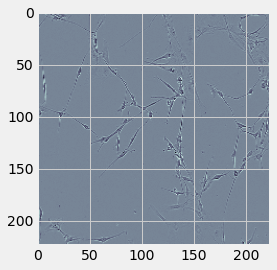

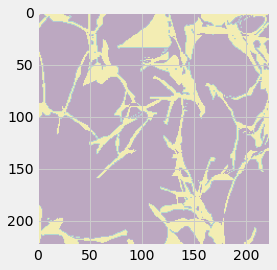

In [15]:
plt.imshow(image[0], cmap='bone')
plt.show()
plt.imshow(mask[0], alpha=0.3)
plt.show()

## **<span style="color:orange;">Dataset Loader</span>**

In [16]:
# Prepare Dataloader

dl_train = DataLoader(
    ds_train, 
    batch_size=64, 
    num_workers=4, 
    pin_memory=True, 
    shuffle=False
)

## **<span style="color:orange;">Losses</span>**

In [17]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

### **<span style="color:orange;">1. Focal Loss</span>**

Focal loss was introduced by Lin et al. in [Focal Loss for Dense Object Detection](https://paperswithcode.com/paper/focal-loss-for-dense-object-detection)

- A **Focal Loss** function addresses class imbalance during training in tasks like object detection. 
  
- Focal loss applies a modulating term to the cross entropy loss in order to focus learning on hard negative examples. 
  
- It is a dynamically scaled cross entropy loss, where the scaling factor decays to zero as confidence in the correct class increases. 
  
- Intuitively, this scaling factor can automatically down-weight the contribution of easy examples during training and rapidly focus the model on hard examples.

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-07_at_4.45.06_PM_leJm2yh.png)

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

### **<span style="color:orange;">2. Focal Loss</span>**

In [19]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

## **<span style="color:orange;">Model</span>**

In [20]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

## **<span style="color:orange;">Training</span>**

In [26]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")
n_batches = len(dl_train)

model.cuda()
model.train()

criterion = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

# Initialize W&B
run = wandb.init(project='sartorius-unet', config=WANDB_CONFIG)

for epoch in range(1, config.EPOCHS + 1):
    print(f"Starting epoch: {epoch} / {config.EPOCHS}")
    running_loss = 0.0
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(dl_train):
        
        # Predict
        images, masks = batch
        images, masks = images.cuda(),  masks.cuda()
        outputs = model(images)
        loss = criterion(outputs, masks)
        wandb.log({"loss": loss})
        
        # Back prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    epoch_loss = running_loss / n_batches
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")
    
wandb.finish()

Starting epoch: 1 / 10
Epoch: 1 - Train Loss 1.3540
Starting epoch: 2 / 10
Epoch: 2 - Train Loss 1.2595
Starting epoch: 3 / 10
Epoch: 3 - Train Loss 1.2038
Starting epoch: 4 / 10
Epoch: 4 - Train Loss 1.1634
Starting epoch: 5 / 10
Epoch: 5 - Train Loss 1.1467
Starting epoch: 6 / 10
Epoch: 6 - Train Loss 1.1559
Starting epoch: 7 / 10
Epoch: 7 - Train Loss 1.1200
Starting epoch: 8 / 10
Epoch: 8 - Train Loss 1.0954
Starting epoch: 9 / 10
Epoch: 9 - Train Loss 1.0790
Starting epoch: 10 / 10
Epoch: 10 - Train Loss 1.0662


loss,▇███▇▆▇▆▆▅▆▅▅▄▅▄▄▄▄▄▄▄▅▄▄▃▅▃▃▃▄▃▃▃▄▃▃▃▄▁
loss,0.99363


## [Check out the run page here $\rightarrow$](https://wandb.ai/ishandutta/sartorius-unet?workspace=)  

<a id="references"></a>
<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>References</center></h2>

>- [🦠 Sartorius - Starter Baseline Torch U-net](https://www.kaggle.com/julian3833/sartorius-starter-baseline-torch-u-net)
>- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://paperswithcode.com/paper/u-net-convolutional-networks-for-biomedical)
>
>---

<h1><center>More Plots and Models coming soon!</center></h1>

<center><img src = "https://static.wixstatic.com/media/5f8fae_7581e21a24a1483085024f88b0949a9d~mv2.jpg/v1/fill/w_934,h_379,al_c,q_90/5f8fae_7581e21a24a1483085024f88b0949a9d~mv2.jpg" width = "750" height = "500"/></center> 

--- 

## **<span style="color:orange;">Let's have a Talk!</span>**
> ### Reach out to me on [LinkedIn](https://www.linkedin.com/in/ishandutta0098)

---